# 9. Breast cancer IMC analysis
## 1. Summary
This notebook quantifies channel features and generates the figures associated with the IMC breast cancer microarray scans comprising Supplementary Figure 1 in the MEZ-XRF paper.

In [1]:
import pathlib
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt

import seaborn as sns

from shutil import copyfile
from imctools.io.mcd.mcdparser import McdParser
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1 import ImageGrid

from skimage import filters
from skimage.transform import rescale, resize, downscale_local_mean

import sys
sys.path.insert(0, '..\\code\\')
from pymca_repack import unpack_pymca_h5, XrfImageMaskHDF
import high_plex_hdf as hph
import utilities

In [2]:
# Set data directory to work from 
base_dir = "C:/Users/MerrickS/OneDrive/Work/2_UZH/Papers/1_MEZ_XRF"
base_dir = pathlib.Path(base_dir)

# Identify analysis directory
analysis_dir = base_dir / 'data' / 'analysis' / 'imc'

# Specify the input directory where hdf files to process are located
input_dir = base_dir / 'data' / 'raw' / 'imc' / '20210721_MS_breast_cancer_MEZXRF_paper_imc'

# Gather filepaths for preprocessed hdfs and config files for XRF fitting
imc_filepath = list(input_dir.glob('*.mcd'))[0]

# Make output directory for unpacked IMC files
out_dir = analysis_dir / '9_IMC_breast_cancer_quantification'
out_dir.mkdir(parents=True, exist_ok=True)
print('IMC breast cancer analysis will be output to: \n\t', out_dir) 

# Import csv of manually determined overlap coordinates between XRF and IMC
df_xrf_imc_overlap = pd.read_csv(base_dir / 'data' / 'raw' / 'imc' / 'imc_xrf_overlap_coords.csv')

# Import periodic table csv
df_periodic_table = pd.read_csv(base_dir / 'data' / 'raw' / 'xrf' / 'Periodic Table of Elements.csv')

IMC breast cancer analysis will be output to: 
	 C:\Users\MerrickS\OneDrive\Work\2_UZH\Papers\1_MEZ_XRF\data\analysis\imc\9_IMC_breast_cancer_quantification


In [3]:
 # Collect experiment antibody panel for additional channel information
panel_path = base_dir / 'data' / 'raw' / 'antibody_panels' / 'breast_cancer_panel.csv'
df_panel = pd.read_csv(panel_path)

#imc_xrf_alignment

In [4]:
sample_coords = df_xrf_imc_overlap[df_xrf_imc_overlap['imc'] == 'col3_row1_rnd1'].to_dict('records')

In [5]:
sample_coords

[{'imc': 'col3_row1_rnd1',
  'xrf': 'overview',
  'x_imc_xrf_centre': 148,
  'y_imc_xrf_centre': 165,
  'pixel': 0.5,
  'x_delta': 1100,
  'y_delta': 800,
  'x_start': 92,
  'x_fin': 1192,
  'y_start': 260,
  'y_fin': 1060},
 {'imc': 'col3_row1_rnd1',
  'xrf': 'roi',
  'x_imc_xrf_centre': 75,
  'y_imc_xrf_centre': 705,
  'pixel': 0.5,
  'x_delta': 275,
  'y_delta': 200,
  'x_start': 0,
  'x_fin': 275,
  'y_start': 605,
  'y_fin': 805}]

In [6]:
acquisition_info = [
    'mcd_filepath',   
    'mcd_filename',   
    'acq_id',
    'acq_id_description',
    'step_um',
    'x_dim', 
    'y_dim',
]

df_standard_measurements = pd.DataFrame(columns=acquisition_info)
roi_dict = dict.fromkeys(acquisition_info)

with McdParser(imc_filepath) as parser:
        roi_dict['mcd_filepath'] = str(imc_filepath)
        roi_dict['mcd_filename'] = str(imc_filepath.name)

        # Get original metadata in XML format
        xml = parser.get_mcd_xml()

        # Get parsed session metadata (i.e. session -> slides -> acquisitions -> channels, panoramas data)
        session = parser.session

        # Get all acquisition IDs
        ids = parser.session.acquisition_ids

        for roi in ids:
            # Get acquisition data for acquisition 
            acq_data = parser.get_acquisition_data(roi)
            
            roi_dict['acq_id'] = roi
            roi_dict['acq_id_description'] = acq_data.acquisition.description
            
            # Check x and y step size consistent before storing as single step size
            assert (
                acq_data.acquisition.ablation_distance_between_shots_x 
                == acq_data.acquisition.ablation_distance_between_shots_y
            )
            roi_dict['step_um'] = acq_data.acquisition.ablation_distance_between_shots_x            
            roi_dict['x_dim'] = acq_data.acquisition.max_x
            roi_dict['y_dim'] = acq_data.acquisition.max_y
                                  
            # Channel info
            df_channels = pd.DataFrame(
                {
                    'channel_labels':acq_data.channel_labels,
                    'channel_masses':acq_data.channel_masses,
                    'channel_names':acq_data.channel_names,
                }
            )
            
            df_channels['channel_masses'] = ( # convert for panel merge
                pd.to_numeric(df_channels['channel_masses'])
            )
            
            
            # Merged channel info
            df_channel_metadata = pd.merge(
                df_channels, 
                df_panel.iloc[:,:6], 
                left_on='channel_masses', 
                right_on='tag_isotope', 
                how='left'
            )     
            
            # Make longname for IMC samples
            df_channel_metadata['shortname'] = df_channel_metadata['shortname'].astype(str)
            df_channel_metadata['longname_imc'] = (
                df_channel_metadata[['channel_names', 'shortname']].agg(' | '.join, axis=1)
            )
            
            # ROI as numpy array
            acq_xarray  = acq_data.to_xarray()
            img_stack = np.moveaxis(
                acq_xarray.values, 
                source=[0, 1, 2], 
                destination=[2, 1, 0]
            )
            img_stack = np.flip(img_stack, axis=1)
            
            img_overview = None
            img_roi = None
            if acq_data.acquisition.description in list(df_xrf_imc_overlap['imc']):
                                
                sample_coords = df_xrf_imc_overlap[
                    (df_xrf_imc_overlap['imc'] == acq_data.acquisition.description) &
                    (df_xrf_imc_overlap['xrf'] == 'overview')
                ].to_dict(orient = 'records')[0]
                                        
                img_overview = img_stack[
                    int(sample_coords['y_start']):int(sample_coords['y_fin']),
                    int(sample_coords['x_start']):int(sample_coords['x_fin']),
                    :
                ]
                delta = {}
                delta['overview'] = sample_coords['y_delta']
                 
                sample_coords = df_xrf_imc_overlap[
                    (df_xrf_imc_overlap['imc'] == acq_data.acquisition.description) &
                    (df_xrf_imc_overlap['xrf'] == 'roi')
                 ].to_dict(orient = 'records')[0]
                                       
                img_roi = img_stack[
                    int(sample_coords['y_start']):int(sample_coords['y_fin']),
                    int(sample_coords['x_start']):int(sample_coords['x_fin']),
                    :
                ]
                delta['roi'] = sample_coords['y_delta']
            
            images = {
                'raw':img_stack
            }
            
            if isinstance(img_overview, (np.ndarray)):
                images['imc_xrf_overview'] = img_overview
                images['imc_xrf_roi'] = img_roi
                
                for crop in ['overview', 'roi']:
                    img_resize = images[f'imc_xrf_{crop}'].copy()
                    images[f'imc_xrf_{crop}_xresize'] = resize(
                        img_resize, (
                            delta[crop],
                            delta[crop],
                            img_resize.shape[-1]
                        )
                    )
            
            images_complete = images.copy()
            for img_lib in images:
                images_complete[f'{img_lib}_subsample_by_4'] = images[img_lib][::4,::4,:]
                       
            roi_hph = XrfImageMaskHDF(
                images = images_complete,
                channel_metadata = df_channel_metadata,
                masks = None,
                sample_metadata=roi_dict
            )
            
            output_fpath = out_dir.joinpath(f"{roi_dict['acq_id_description']}.h5")
            
            roi_hph.export_hdf(
                output_fpath = output_fpath
            )
            
            print(img_stack.shape, len(df_channels))
            print(images_complete.keys())
            

C:\Users\MerrickS\Anaconda3\envs\mez-xrf\lib\site-packages\pandas\core\generic.py:2606: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['channel_labels', 'channel_names', 'ab_tag', 'xrf_emission', 'target',
       'shortname', 'ab_clone', 'longname_imc'],
      dtype='object')]

  pytables.to_hdf(


(400, 400, 74) 74
dict_keys(['raw', 'raw_subsample_by_4'])
(1360, 1360, 74) 74
dict_keys(['raw', 'imc_xrf_overview', 'imc_xrf_roi', 'imc_xrf_overview_xresize', 'imc_xrf_roi_xresize', 'raw_subsample_by_4', 'imc_xrf_overview_subsample_by_4', 'imc_xrf_roi_subsample_by_4', 'imc_xrf_overview_xresize_subsample_by_4', 'imc_xrf_roi_xresize_subsample_by_4'])
(1360, 1360, 74) 74
dict_keys(['raw', 'imc_xrf_overview', 'imc_xrf_roi', 'imc_xrf_overview_xresize', 'imc_xrf_roi_xresize', 'raw_subsample_by_4', 'imc_xrf_overview_subsample_by_4', 'imc_xrf_roi_subsample_by_4', 'imc_xrf_overview_xresize_subsample_by_4', 'imc_xrf_roi_xresize_subsample_by_4'])
(1360, 1360, 74) 74
dict_keys(['raw', 'imc_xrf_overview', 'imc_xrf_roi', 'imc_xrf_overview_xresize', 'imc_xrf_roi_xresize', 'raw_subsample_by_4', 'imc_xrf_overview_subsample_by_4', 'imc_xrf_roi_subsample_by_4', 'imc_xrf_overview_xresize_subsample_by_4', 'imc_xrf_roi_xresize_subsample_by_4'])
(1360, 1360, 74) 74
dict_keys(['raw', 'raw_subsample_by_4'])
(

In [7]:
hdf_paths = list(out_dir.glob('*.h5'))
hdf_dict = {i.stem:i for i in hdf_paths}

In [8]:
hdf_dict

{'col1_row1_rnd1': WindowsPath('C:/Users/MerrickS/OneDrive/Work/2_UZH/Papers/1_MEZ_XRF/data/analysis/imc/9_IMC_breast_cancer_quantification/col1_row1_rnd1.h5'),
 'col1_row1_rnd2': WindowsPath('C:/Users/MerrickS/OneDrive/Work/2_UZH/Papers/1_MEZ_XRF/data/analysis/imc/9_IMC_breast_cancer_quantification/col1_row1_rnd2.h5'),
 'col3_row1_rnd1': WindowsPath('C:/Users/MerrickS/OneDrive/Work/2_UZH/Papers/1_MEZ_XRF/data/analysis/imc/9_IMC_breast_cancer_quantification/col3_row1_rnd1.h5'),
 'col3_row1_rnd1_extra': WindowsPath('C:/Users/MerrickS/OneDrive/Work/2_UZH/Papers/1_MEZ_XRF/data/analysis/imc/9_IMC_breast_cancer_quantification/col3_row1_rnd1_extra.h5'),
 'col3_row1_rnd2': WindowsPath('C:/Users/MerrickS/OneDrive/Work/2_UZH/Papers/1_MEZ_XRF/data/analysis/imc/9_IMC_breast_cancer_quantification/col3_row1_rnd2.h5'),
 'col3_row2_rnd1': WindowsPath('C:/Users/MerrickS/OneDrive/Work/2_UZH/Papers/1_MEZ_XRF/data/analysis/imc/9_IMC_breast_cancer_quantification/col3_row2_rnd1.h5'),
 'col3_row2_rnd2': Win

In [9]:
def multi_hph_plot(hph_fpath_dict, hph_list, img_lib, channels, pxl, scale, color_bar_label):
    """
    Function to plot multiple hph_paths
    
    :param hph_fpath_dict: dicitonary of hph filenames and filepaths
    :param hph_list: ordered list of hph files to plot from hph dict
    :param img_lib: image node from hph['images'] of hph files to plot
    :param channels: ordered list of channels to plot
    """
    
    fig = plt.figure(
        figsize=(3*len(hph_list), 3*len(channels)), 
        dpi=300
    )

    grid = ImageGrid(
        fig, 111,          # as in plt.subplot(111)
        nrows_ncols=(len(channels), len(hph_list)),
        axes_pad=0.1,
        share_all=True,
        cbar_mode="edge",
        cbar_location="right",
        cbar_size="5%",
        cbar_pad=0.1,
    )

    grid_counter = 0
    for row, channel in enumerate(channels):

        img_max = dict.fromkeys(hph_list)
        img_min = dict.fromkeys(hph_list)

        # Get min max values for row
        for hph_roi in hph_list:
            hph_hdf = hph.hdf_to_HighPlex_Hdf(hph_fpath_dict[hph_roi])

            plot_channels = hph_hdf.channel_metadata[
                (hph_hdf.channel_metadata['shortname'] != 'nan') &
                (hph_hdf.channel_metadata['xrf_emission'].isin(channels))    
            ]

            idx = plot_channels[plot_channels['xrf_emission'] == channel].index
            img = hph_hdf.images[img_lib][:,:,idx]

            low_p, high_p = np.percentile(img, [0.5,99.5])
            img_min[hph_roi] = low_p
            img_max[hph_roi] = high_p

        vmin=min(img_min.values())
        vmax=max(img_max.values())

        # Set colorbar for row
        cax = grid.cbar_axes[row]        
        cbar = plt.colorbar(
            plt.cm.ScalarMappable(
                norm=plt.Normalize(
                    vmin=vmin, 
                    vmax=vmax,
                ), 
                cmap='gray'
            ), 
            cax=cax,
        )
        
        # Pad tick labels for consistent width
        tick_labels = [tick for tick in cbar.ax.get_yticks()]
        if np.max(tick_labels) < 10:
            tick_labels_padded = ['{0: <4}'.format(round(lbl,1)) for lbl in tick_labels]
        else:
            tick_labels_padded = ['{0: <4d}'.format(int(lbl)) for lbl in tick_labels]
        cbar.ax.set_yticklabels(tick_labels_padded)  # vertically oriented colorbar
        
        cbar.set_label(
            color_bar_label, 
            rotation=270,
            labelpad=17,
            fontsize = 14
        )

        # Plot channel per sample
        for hph_roi in hph_list:
            hph_hdf = hph.hdf_to_HighPlex_Hdf(hph_fpath_dict[hph_roi])
            img = hph_hdf.images[img_lib][:,:,idx]

            img = filters.gaussian(img, sigma=0.8)

            grid[grid_counter].imshow(
                hph_hdf.images[img_lib][:,:,idx],
                vmin=vmin,
                vmax=vmax,
                cmap = 'gray'
            )

            grid[grid_counter].axis('off')

            grid[grid_counter].text(
                0.03, 0.97, 
                s = plot_channels['longname_imc'][
                    plot_channels['xrf_emission'] == channel
                ].iloc[0],
                horizontalalignment='left', 
                verticalalignment='top', 
                transform=grid[grid_counter].transAxes,
                fontsize=18,
                color='white',
                bbox=dict(facecolor='black', alpha=0.5)
            )

            scalebar = ScaleBar(
                        pxl,
                        "um", 
                        fixed_value=scale,
                        location='lower right',
                        width_fraction=0.04,
                        color='white',
                        scale_loc='top',
                        box_alpha=0.5,
                        box_color='black',
                        font_properties={'size':14},
                    )
            grid[grid_counter].add_artist(scalebar)

            grid_counter =  grid_counter+1


<ipython-input-9-3f76bd7c80e8>:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(tick_labels_padded)  # vertically oriented colorbar


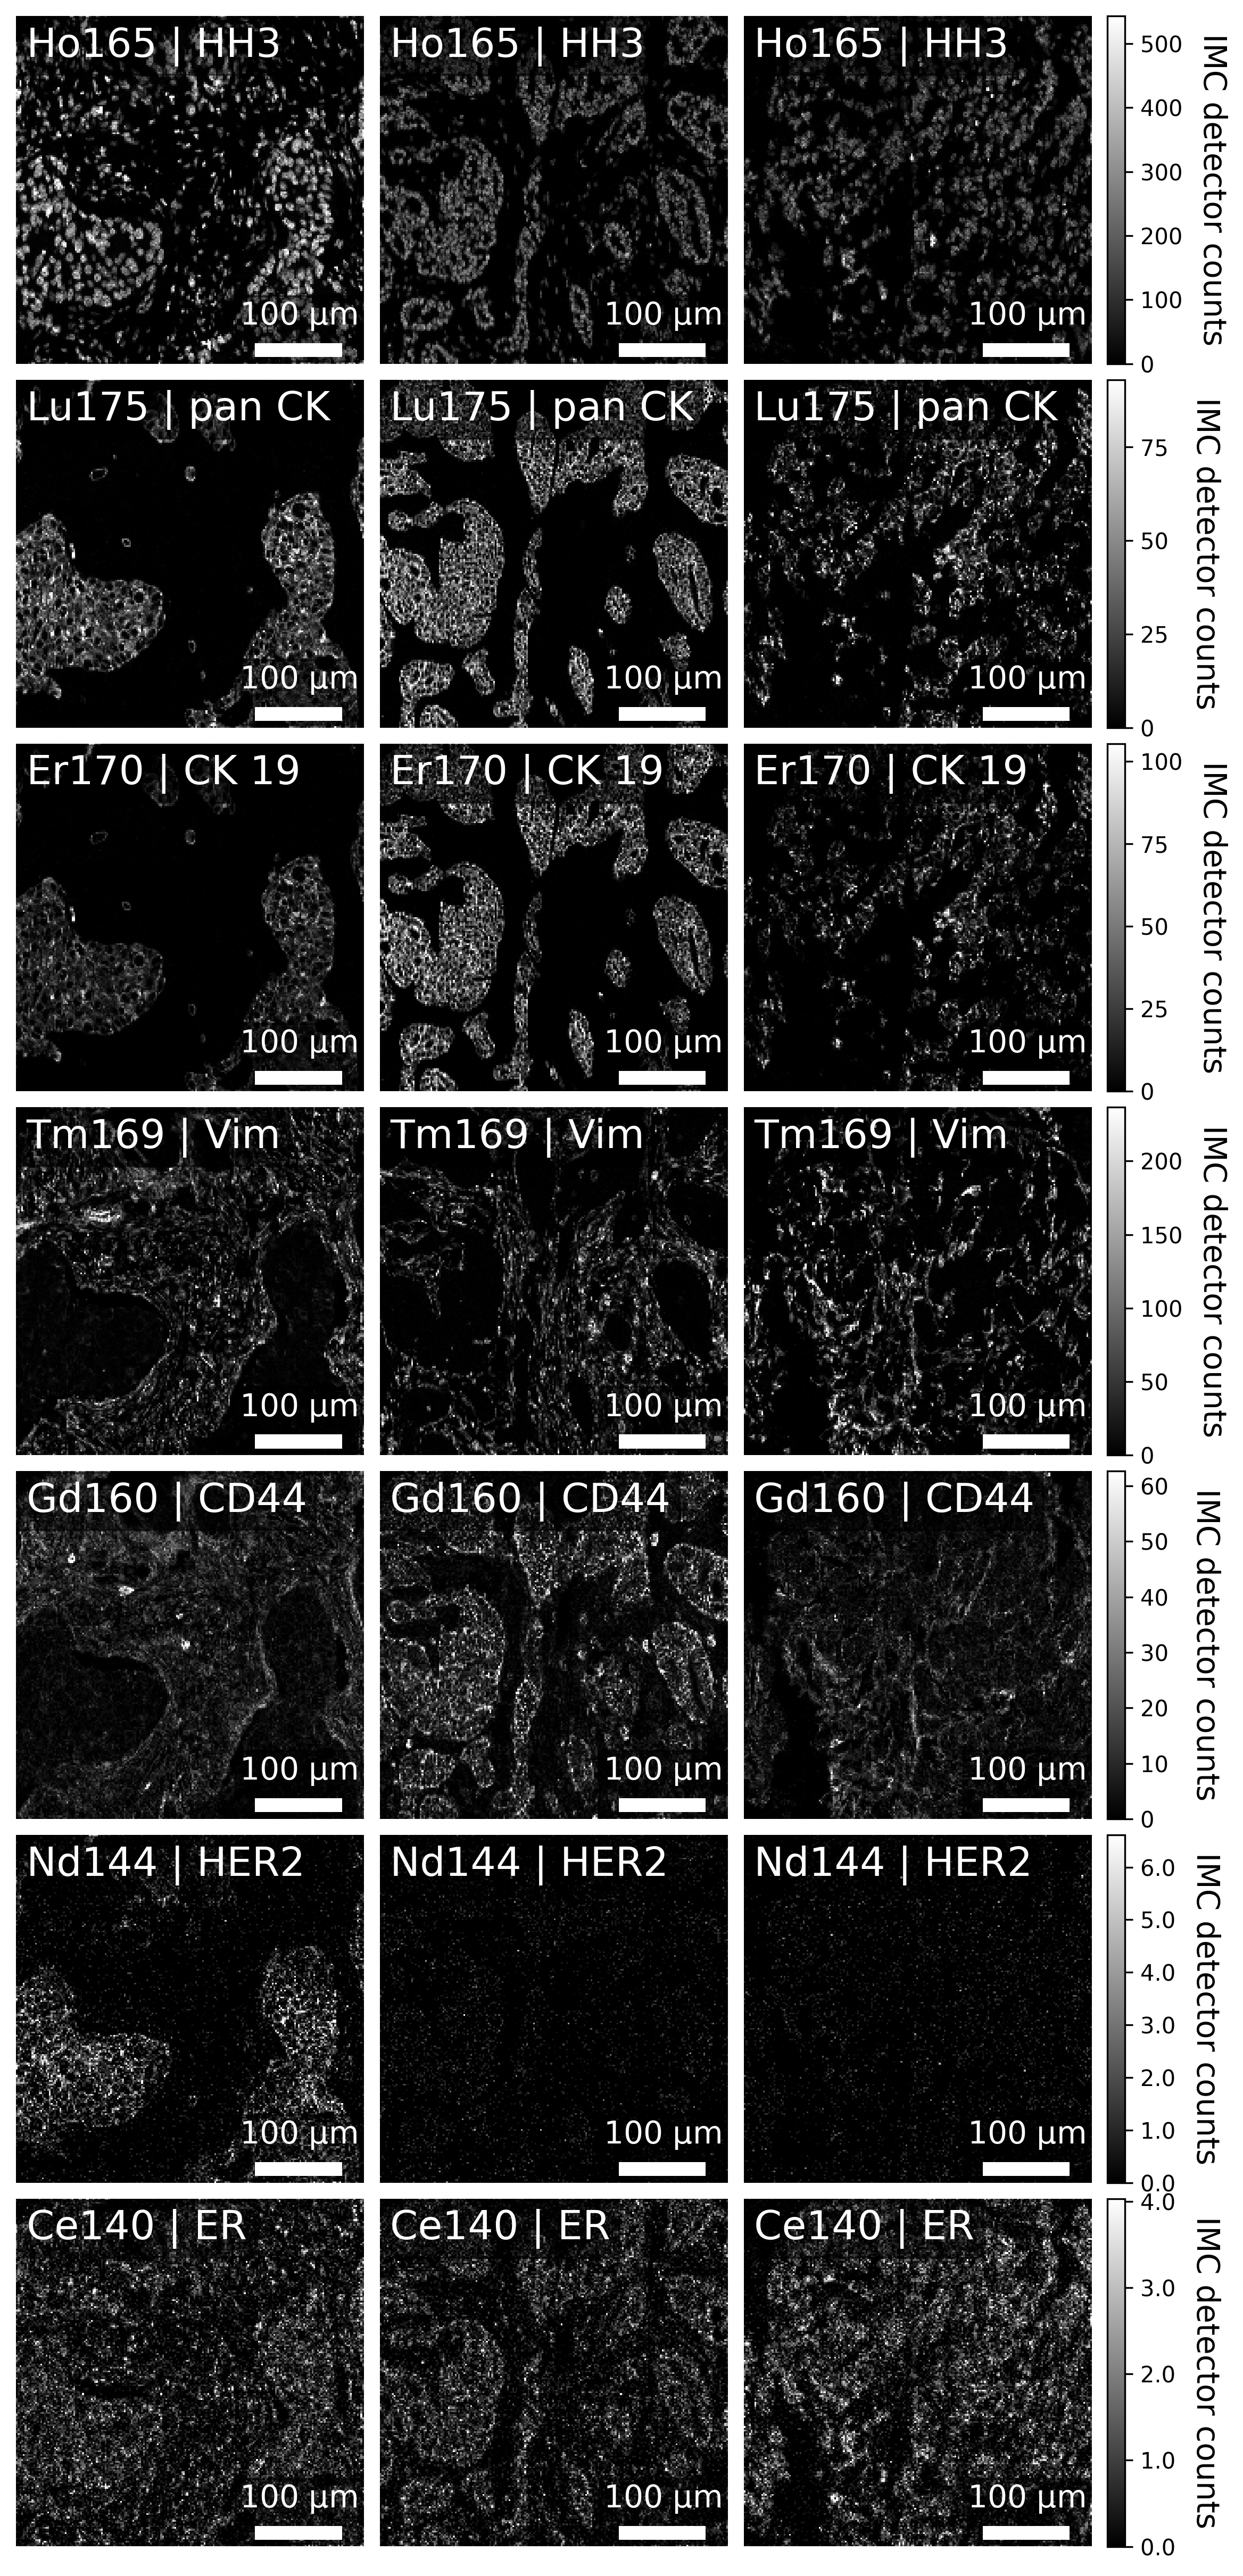

In [10]:
hph_list = ['col3_row1_rnd1', 'col3_row2_rnd1', 'col3_row3_rnd1']

fig_channels_1= [
    'Ho_Ka', 
    'Lu_Ka', 
    'Er_Ka',
    'Tm_Ka', 
    'Gd_Ka',
    'Nd_Ka', 
    'Ce_Ka',
]

multi_hph_plot(
    hph_fpath_dict = hdf_dict, 
    hph_list = hph_list, 
    img_lib = 'imc_xrf_overview_xresize_subsample_by_4', 
    channels = fig_channels_1,
    pxl=2,
    scale=100,
    color_bar_label = 'IMC detector counts'
)

<ipython-input-9-3f76bd7c80e8>:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(tick_labels_padded)  # vertically oriented colorbar


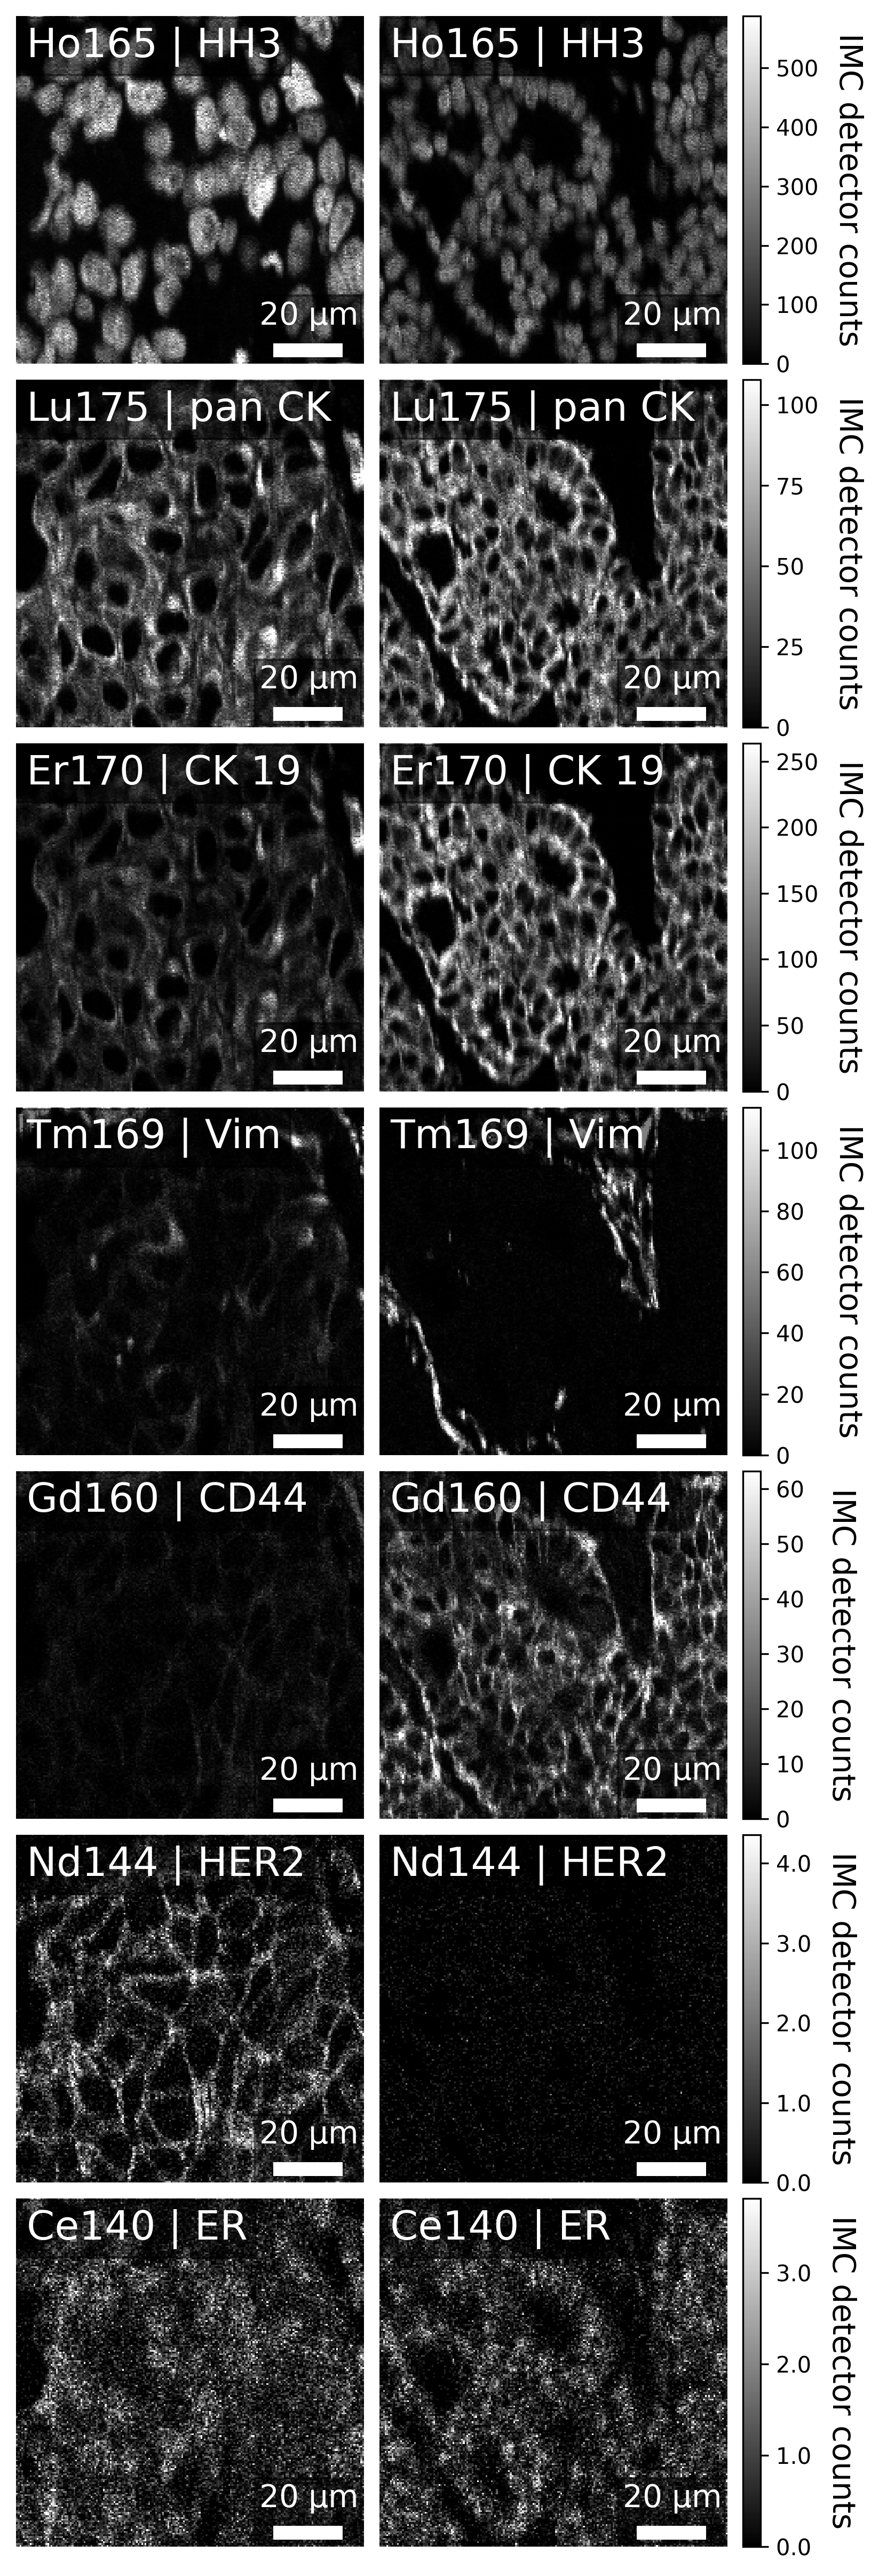

In [11]:
multi_hph_plot(
    hph_fpath_dict = hdf_dict, 
    hph_list = hph_list[:-1], 
    img_lib = 'imc_xrf_roi_xresize', 
    channels = fig_channels_1,
    pxl=0.5,
    scale=20,
    color_bar_label = 'IMC detector counts'
)

<ipython-input-9-3f76bd7c80e8>:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(tick_labels_padded)  # vertically oriented colorbar


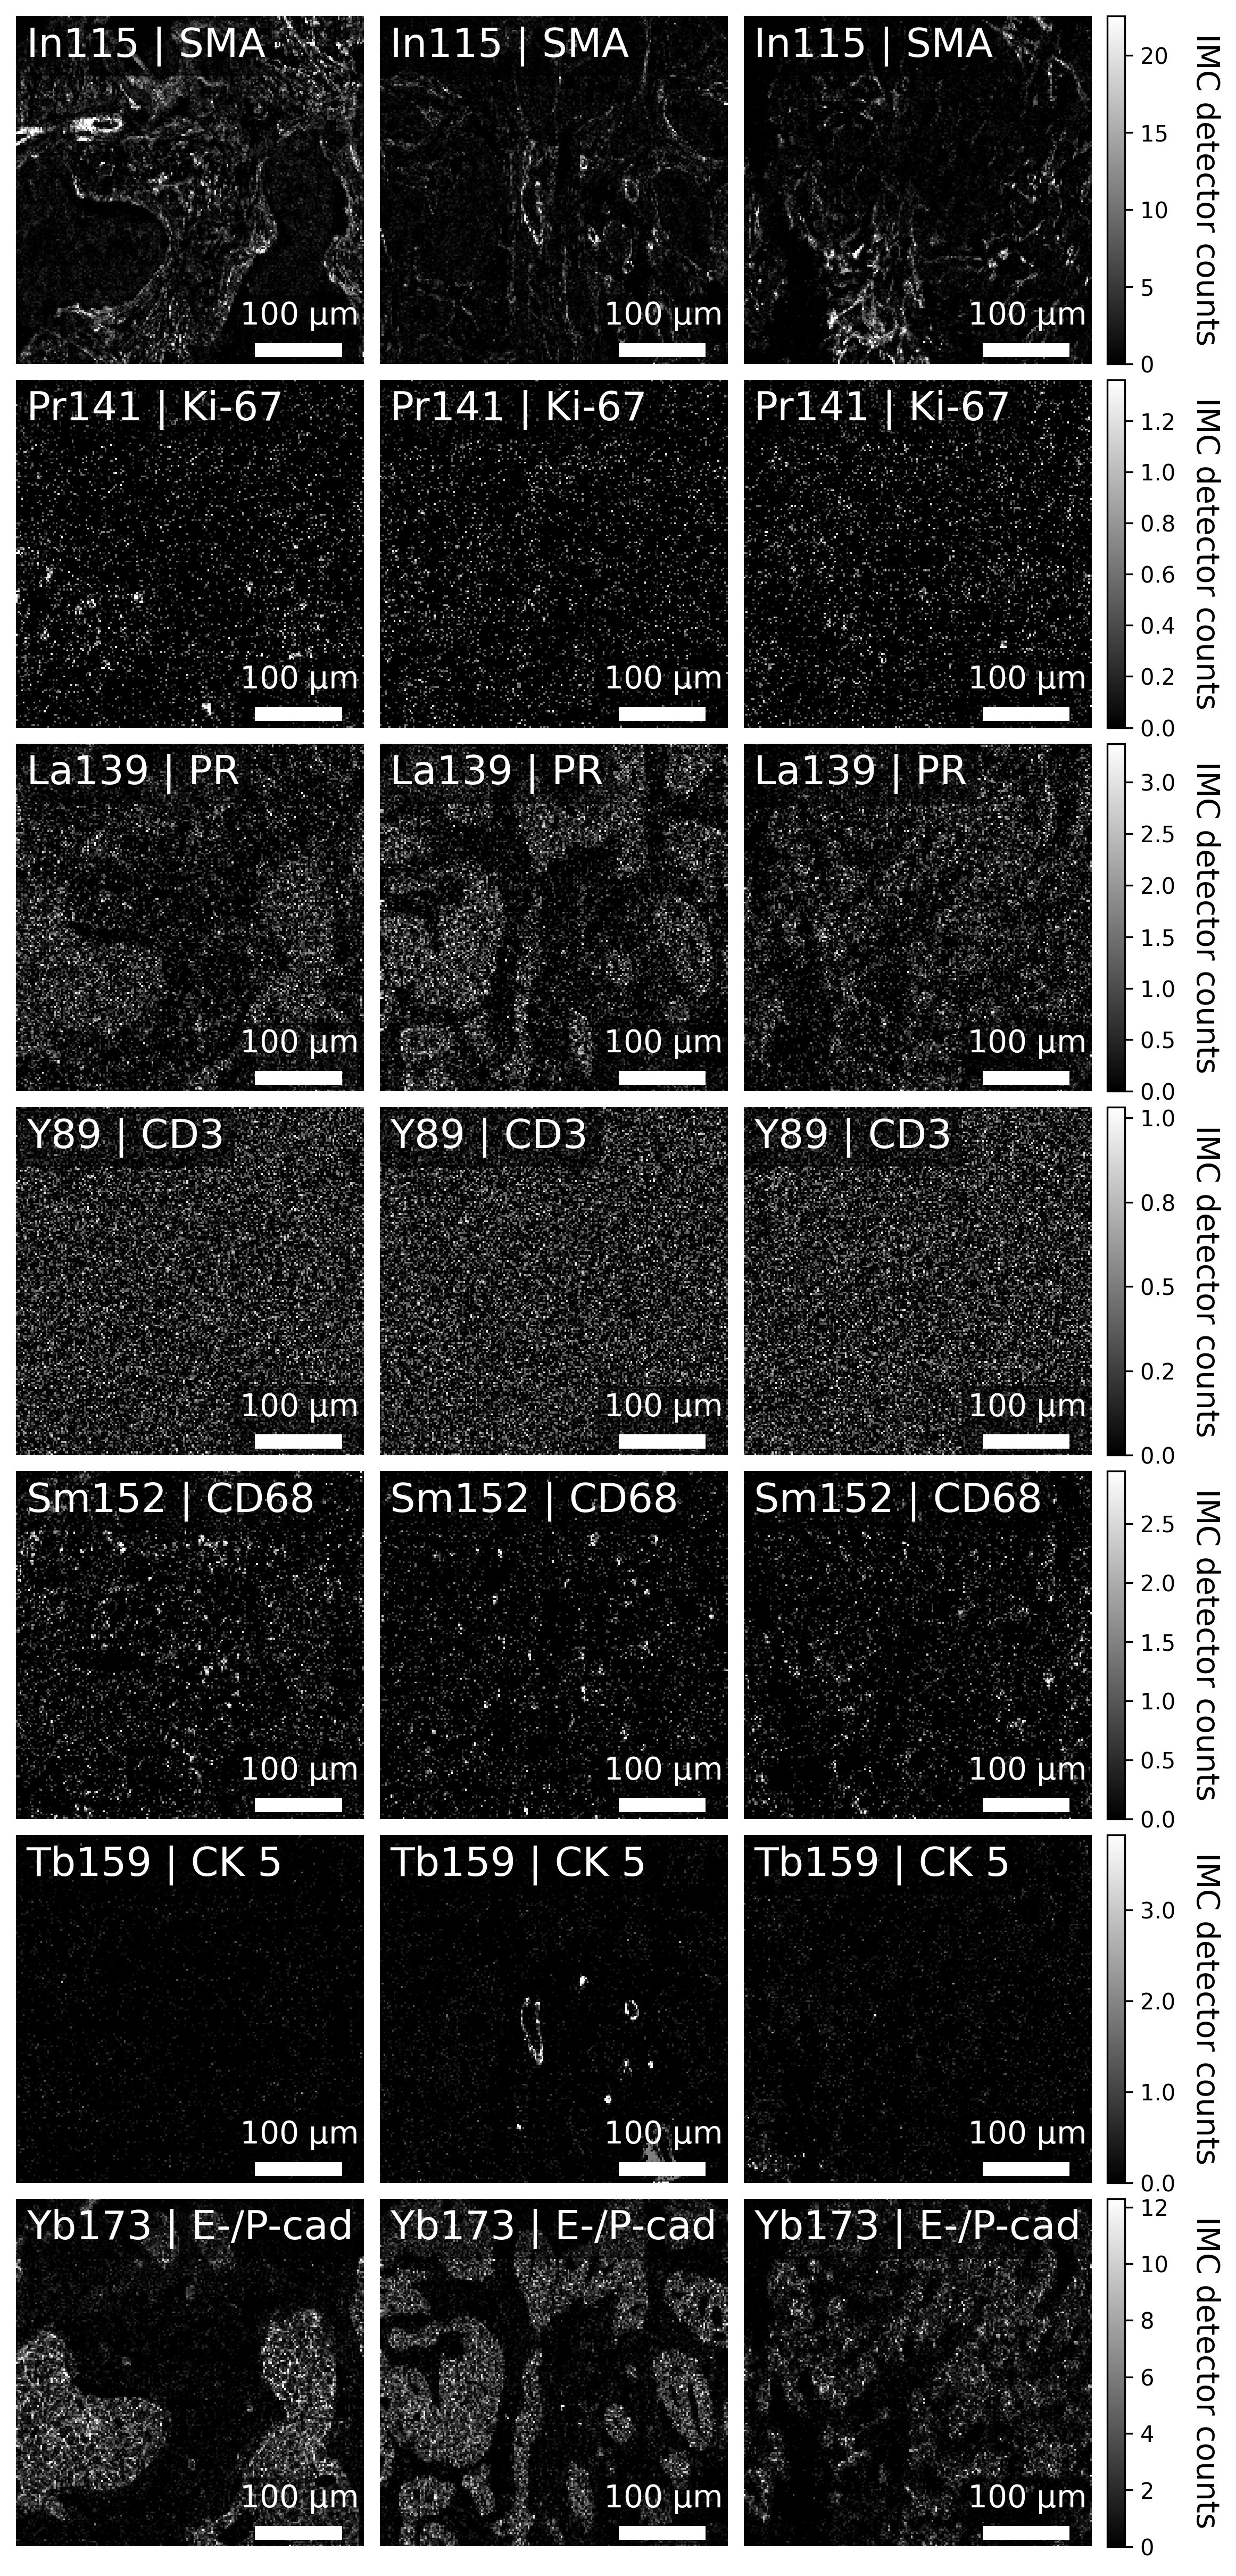

In [12]:
fig_channels_2= [
    'In_Ka',
    'Pr_Ka',
    'La_Ka',
    'Y_Ka',
    'Sm_Ka',
    'Tb_Ka',
    'Yb_Ka'
]

multi_hph_plot(
    hph_fpath_dict = hdf_dict, 
    hph_list = hph_list, 
    img_lib = 'imc_xrf_overview_xresize_subsample_by_4', 
    channels = fig_channels_2,
    pxl=2,
    scale=100,
    color_bar_label = 'IMC detector counts'
)

In [13]:
sup6_channels = ['Pr_Ka', 'Yb_Ka']
print(fig_channels_2)
print(sup6_channels)

['In_Ka', 'Pr_Ka', 'La_Ka', 'Y_Ka', 'Sm_Ka', 'Tb_Ka', 'Yb_Ka']
['Pr_Ka', 'Yb_Ka']


<ipython-input-9-3f76bd7c80e8>:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(tick_labels_padded)  # vertically oriented colorbar


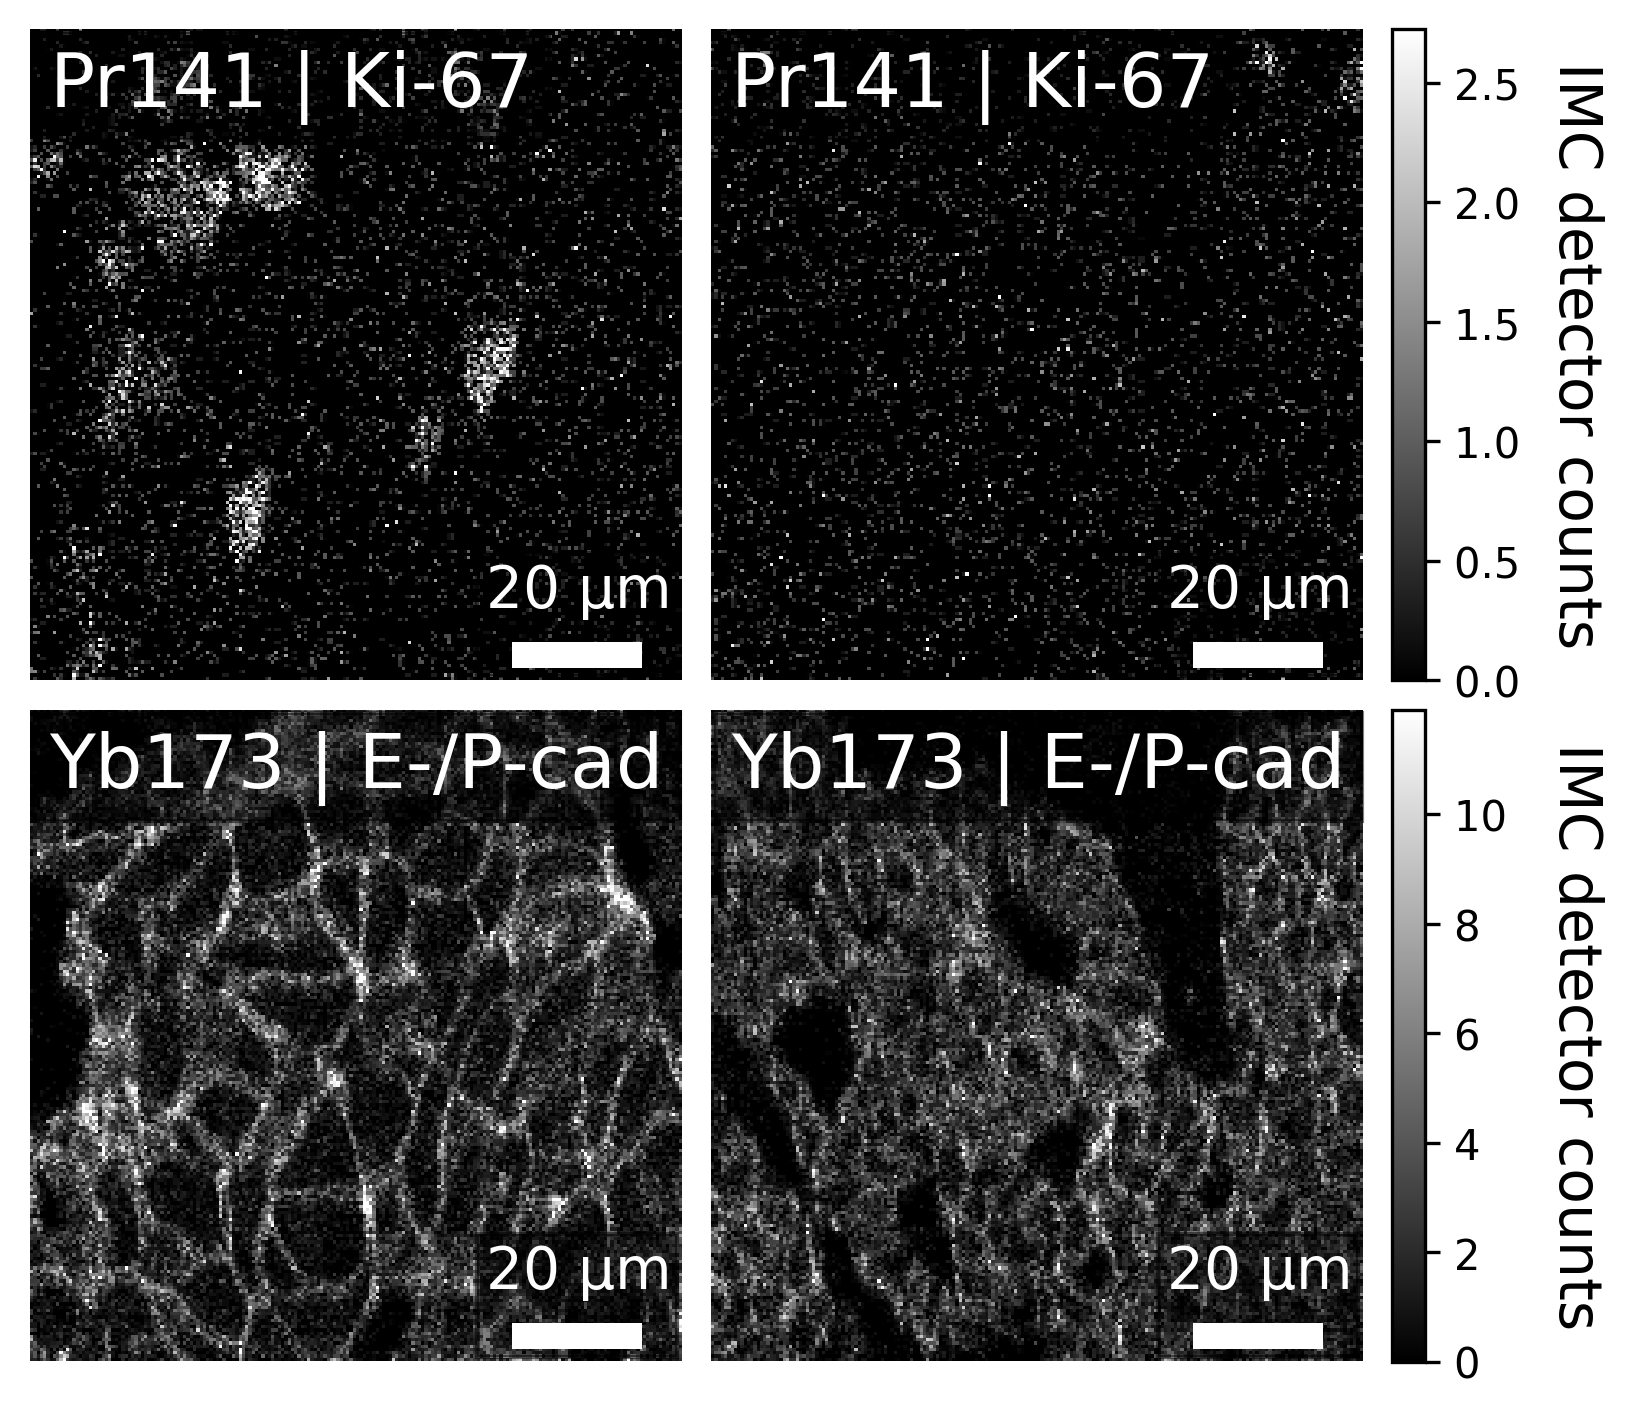

In [14]:
multi_hph_plot(
    hph_fpath_dict = hdf_dict, 
    hph_list = hph_list[:-1], 
    img_lib = 'imc_xrf_roi_xresize', 
    channels = sup6_channels,
    pxl=0.5,
    scale=20,
    color_bar_label = 'IMC detector counts'
)